<a href="https://colab.research.google.com/github/ZygoOoade/Graphisms/blob/master/Convert_SVG_to_TIKZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import xml.etree.ElementTree as ET
import re

def parse_transform(transform):
    if not transform:
        return 0, 0
    match = re.search(r'translate\(([-\d.]+),\s*([-\d.]+)\)', transform)
    if match:
        return float(match.group(1)), float(match.group(2))
    return 0, 0

def parse_style(style):
    styles = {}
    if style:
        for item in style.split(';'):
            if ':' in item:
                key, value = item.split(':')
                styles[key.strip()] = value.strip()
    return styles

def svg_to_tikz(svg_path, tikz_path):
    # Parse the SVG file
    tree = ET.parse(svg_path)
    root = tree.getroot()

    # Extract viewBox and calculate scale
    viewbox = root.attrib.get('viewBox', '0 0 100 100').split()
    width, height = float(viewbox[2]), float(viewbox[3])
    scale_x = float(root.attrib.get('width', width).rstrip('mm')) / width
    scale_y = float(root.attrib.get('height', height).rstrip('mm')) / height

    # Start TikZ content
    tikz_content = [
        r"\begin{tikzpicture}",
        r"  \begin{scope}[x=1mm,y=1mm,yscale=-1,xscale=1]"
    ]

    # Convert SVG elements to TikZ commands
    for elem in root.iter():
        if elem.tag.endswith('line'):
            x1 = float(elem.attrib.get('x1', 0)) * scale_x
            y1 = height * scale_y - float(elem.attrib.get('y1', 0)) * scale_y
            x2 = float(elem.attrib.get('x2', 0)) * scale_x
            y2 = height * scale_y - float(elem.attrib.get('y2', 0)) * scale_y
            style = parse_style(elem.attrib.get('style', ''))
            stroke = style.get('stroke', 'black')
            dash = 'dashed' if 'stroke-dasharray' in style else ''
            tikz_content.append(f"    \draw[{stroke},{dash}] ({x1:.2f},{y1:.2f}) -- ({x2:.2f},{y2:.2f});")

        elif elem.tag.endswith('text'):
            x = float(elem.attrib.get('x', '0')) * scale_x
            y = height * scale_y - float(elem.attrib.get('y', '0')) * scale_y
            text = elem.text if elem.text else ""
            font_size = elem.attrib.get('font-size', '10').rstrip('px')
            transform = elem.attrib.get('transform', '')

            tx, ty = parse_transform(transform)
            x += tx * scale_x
            y -= ty * scale_y

            # Escape special LaTeX characters
            text = text.replace('&', r'\&').replace('%', r'\%').replace('#', r'\#')

            if text.strip():  # Only add non-empty text nodes
                tikz_content.append(f"    \\node[font=\\fontsize{{{font_size}pt}}{{12pt}}\\selectfont] at ({x:.2f},{y:.2f}) {{{text}}};")

    # End TikZ content
    tikz_content.extend([
        r"  \end{scope}",
        r"\end{tikzpicture}"
    ])

    # Write TikZ content to file
    with open(tikz_path, 'w') as f:
        f.write('\n'.join(tikz_content))

    print(f"Conversion complete. TikZ file saved as {tikz_path}")

# Usage
svg_file = '/content/file.svg'
tikz_file = '/content/output.tikz'
svg_to_tikz(svg_file, tikz_file)

Conversion complete. TikZ file saved as /content/output.tikz


In [26]:
import xml.etree.ElementTree as ET
import re

def parse_transform(transform):
    """Parse the 'transform' attribute to handle translations."""
    if not transform:
        return 0, 0
    match = re.search(r'translate\(([-\d.]+),\s*([-\d.]+)\)', transform)
    if match:
        return float(match.group(1)), float(match.group(2))
    return 0, 0

def parse_style(style, classes, class_name):
    """Parse inline styles and class styles to get the final style of the element."""
    styles = {}
    if class_name and class_name in classes:
        styles.update(classes[class_name])
    if style:
        for item in style.split(';'):
            if ':' in item:
                key, value = item.split(':')
                styles[key.strip()] = value.strip()
    return styles

def parse_defs(root):
    """Parses class styles from the <defs> section of the SVG."""
    classes = {}
    for style in root.findall('.//{http://www.w3.org/2000/svg}style'):
        css_content = style.text
        class_defs = re.findall(r'(\.cls-\d+)\s*{([^}]*)}', css_content)
        for class_name, properties in class_defs:
            class_styles = {}
            for prop in properties.split(';'):
                if ':' in prop:
                    key, value = prop.split(':')
                    class_styles[key.strip()] = value.strip()
            classes[class_name[1:]] = class_styles  # Remove leading dot from class name
    return classes

def svg_to_tikz(svg_path, tikz_path):
    """Converts an SVG file to TikZ code."""
    # Parse the SVG file
    tree = ET.parse(svg_path)
    root = tree.getroot()

    # Parse class styles from the defs section
    classes = parse_defs(root)

    # Extract viewBox and calculate scale
    viewbox = root.attrib.get('viewBox', '0 0 100 100').split()
    width, height = float(viewbox[2]), float(viewbox[3])
    scale_x = float(root.attrib.get('width', width).rstrip('mm')) / width
    scale_y = float(root.attrib.get('height', height).rstrip('mm')) / height

    # Start TikZ content
    tikz_content = [
        r"\begin{tikzpicture}",
        r"  \begin{scope}[x=1mm,y=1mm,yscale=-1,xscale=1]"
    ]

    # Convert SVG elements to TikZ commands
    for elem in root.iter():
        tag = elem.tag.split('}')[-1]  # Remove namespace
        if tag == 'line':
            x1 = float(elem.attrib.get('x1', 0)) * scale_x
            y1 = height * scale_y - float(elem.attrib.get('y1', 0)) * scale_y
            x2 = float(elem.attrib.get('x2', 0)) * scale_x
            y2 = height * scale_y - float(elem.attrib.get('y2', 0)) * scale_y
            style = parse_style(elem.attrib.get('style', ''), classes, elem.attrib.get('class', ''))
            stroke = style.get('stroke', 'black')
            dash = 'dashed' if 'stroke-dasharray' in style else ''
            tikz_content.append(f"    \draw[{stroke},{dash}] ({x1:.2f},{y1:.2f}) -- ({x2:.2f},{y2:.2f});")

        elif tag == 'text':
            x = float(elem.attrib.get('x', '0')) * scale_x
            y = height * scale_y - float(elem.attrib.get('y', '0')) * scale_y
            text = elem.text if elem.text else ""
            font_size = elem.attrib.get('font-size', '10').rstrip('px')
            transform = elem.attrib.get('transform', '')

            tx, ty = parse_transform(transform)
            x += tx * scale_x
            y -= ty * scale_y

            # Escape special LaTeX characters
            text = text.replace('&', r'\&').replace('%', r'\%').replace('#', r'\#')

            if text.strip():  # Only add non-empty text nodes
                tikz_content.append(f"    \\node[font=\\fontsize{{{font_size}pt}}{{12pt}}\\selectfont] at ({x:.2f},{y:.2f}) {{{text}}};")

    # End TikZ content
    tikz_content.extend([
        r"  \end{scope}",
        r"\end{tikzpicture}"
    ])

    # Write TikZ content to file
    with open(tikz_path, 'w') as f:
        f.write('\n'.join(tikz_content))

    print(f"Conversion complete. TikZ file saved as {tikz_path}")


# Paths to SVG input and TikZ output files
svg_file = 'file.svg'
tikz_file = 'path_to_output.tikz'
svg_to_tikz(svg_file, tikz_file)


Conversion complete. TikZ file saved as path_to_output.tikz


Parsed transform coordinates: ['158.52', '89.7']
Parsed transform coordinates: ['76.03', '53.31']
Parsed transform coordinates: ['125.44', '62.07']
Parsed transform coordinates: ['171.2', '132.4']
Parsed transform coordinates: ['75.94', '76.52']
Parsed transform coordinates: ['154.55', '109.46']
Parsed transform coordinates: ['95.47', '61.95']
Parsed transform coordinates: ['145.3', '74.08']
Parsed transform coordinates: ['156.97', '74.08']
Parsed transform coordinates: ['161.65', '74.08']
Parsed transform coordinates: ['159.82', '146.51']
Parsed transform coordinates: ['104.12', '55.36']
Parsed transform coordinates: ['170.16', '98.37']
Parsed transform coordinates: ['89.7', '8.8']
Parsed transform coordinates: ['39.17', '176.36']
Parsed transform coordinates: ['138.77', '143.08']
Parsed transform coordinates: ['57.03', '167.58']
Parsed transform coordinates: ['61.86', '186.33']
Parsed transform coordinates: ['167.89', '139.48']
Parsed transform coordinates: ['81.08', '22.56']
Parsed 

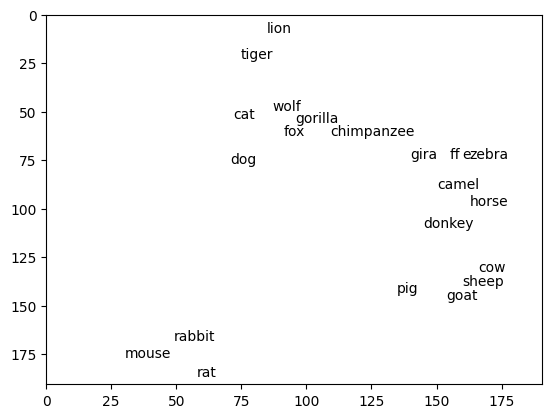

In [40]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import re

# Function to extract the coordinates from a 'transform' attribute
def parse_transform(transform):
    match = re.search(r"translate\((.*?)\)", transform)
    if match:
        # Split by any whitespace or comma
        coords = re.split(r'[,\s]+', match.group(1).strip())
        print(f"Parsed transform coordinates: {coords}")
        # Now coords[0] should be the x value and coords[1] should be the y value
        x_trans = float(coords[0])
        y_trans = float(coords[1]) if len(coords) > 1 else 0
        return x_trans, y_trans
    return 0, 0


# Function to extract text elements and their coordinates
def extract_text_coordinates(root):
    text_positions = []

    for text_element in root.iter('{http://www.w3.org/2000/svg}text'):
        # Extract position and content of each text element
        x = float(text_element.attrib.get('x', 0))  # Default to 0 if x not found
        y = float(text_element.attrib.get('y', 0))  # Default to 0 if y not found

        # Handle 'transform' attribute if present
        transform = text_element.attrib.get('transform')
        if transform:
            x_trans, y_trans = parse_transform(transform)
            x += x_trans
            y += y_trans

        text = ''.join(text_element.itertext()).strip()
        text_positions.append((x, y, text))

    return text_positions

# Load the SVG file
svg_content = '''<svg id="Calque_1" data-name="Calque 1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" width="67.23mm" height="67.23mm" viewBox="0 0 190.57 190.57">
  <defs>
    <style>
      .cls-1, .cls-4 {
        fill: none;
      }

      .cls-2 {
        clip-path: url(#clip-path);
      }

      .cls-3 {
        clip-path: url(#clip-path-2);
      }

      .cls-4 {
        stroke: #d1d1e1;
        stroke-miterlimit: 10;
        stroke-width: 0.44px;
        stroke-dasharray: 1.1 1.1;
      }

      .cls-5 {
        clip-path: url(#clip-path-3);
      }

      .cls-6 {
        clip-path: url(#clip-path-4);
      }

      .cls-7 {
        clip-path: url(#clip-path-5);
      }

      .cls-8 {
        clip-path: url(#clip-path-6);
      }

      .cls-9 {
        clip-path: url(#clip-path-7);
      }

      .cls-10 {
        clip-path: url(#clip-path-8);
      }

      .cls-11 {
        clip-path: url(#clip-path-9);
      }

      .cls-12 {
        clip-path: url(#clip-path-10);
      }

      .cls-13 {
        clip-path: url(#clip-path-11);
      }

      .cls-14 {
        clip-path: url(#clip-path-12);
      }

      .cls-15, .cls-20, .cls-29, .cls-39, .cls-45 {
        font-size: 6.24px;
        fill: #4d414c;
        font-family: DejaVuSans;
      }

      .cls-16, .cls-20 {
        letter-spacing: -0.05em;
      }

      .cls-17 {
        letter-spacing: 0.01em;
      }

      .cls-18 {
        letter-spacing: 0.03em;
      }

      .cls-19 {
        letter-spacing: 0.01em;
      }

      .cls-21, .cls-39 {
        letter-spacing: -0.01em;
      }

      .cls-22 {
        letter-spacing: -0.03em;
      }

      .cls-23 {
        letter-spacing: 0.02em;
      }

      .cls-24 {
        letter-spacing: -0.01em;
      }

      .cls-25 {
        letter-spacing: 0.01em;
      }

      .cls-26 {
        letter-spacing: -0.02em;
      }

      .cls-27 {
        letter-spacing: 0em;
      }

      .cls-28 {
        letter-spacing: 0.01em;
      }

      .cls-29, .cls-31 {
        letter-spacing: -0.01em;
      }

      .cls-30 {
        letter-spacing: 0em;
      }

      .cls-32 {
        letter-spacing: -0.01em;
      }

      .cls-33 {
        letter-spacing: -0.08em;
      }

      .cls-34 {
        letter-spacing: 0.01em;
      }

      .cls-35 {
        letter-spacing: 0.02em;
      }

      .cls-36 {
        letter-spacing: -0.03em;
      }

      .cls-37, .cls-45 {
        letter-spacing: -0.04em;
      }

      .cls-38 {
        letter-spacing: -0.03em;
      }

      .cls-40 {
        letter-spacing: -0.02em;
      }

      .cls-41 {
        letter-spacing: 0.01em;
      }

      .cls-42 {
        letter-spacing: 0.01em;
      }

      .cls-43 {
        letter-spacing: -0.01em;
      }

      .cls-44 {
        letter-spacing: 0.01em;
      }

      .cls-46 {
        letter-spacing: -0.02em;
      }

      .cls-47 {
        letter-spacing: -0.01em;
      }

      .cls-48 {
        letter-spacing: 0.06em;
      }
    </style>
    <clipPath id="clip-path" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="-67.67" y="-9.49" width="312.52" height="220.99"/>
    </clipPath>
    <clipPath id="clip-path-2" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="1.36" y="186.97" width="190.57" height="1.56"/>
    </clipPath>
    <clipPath id="clip-path-3" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="1.36" y="156.56" width="190.57" height="1.56"/>
    </clipPath>
    <clipPath id="clip-path-4" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="1.36" y="126.16" width="190.57" height="1.56"/>
    </clipPath>
    <clipPath id="clip-path-5" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="1.36" y="96.54" width="190.57" height="0.78"/>
    </clipPath>
    <clipPath id="clip-path-6" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="1.36" y="66.13" width="190.57" height="0.78"/>
    </clipPath>
    <clipPath id="clip-path-7" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="1.36" y="35.73" width="190.57" height="0.78"/>
    </clipPath>
    <clipPath id="clip-path-8" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="1.36" y="5.32" width="190.57" height="1.56"/>
    </clipPath>
    <clipPath id="clip-path-9" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="4.83" y="1.56" width="1.56" height="190.57"/>
    </clipPath>
    <clipPath id="clip-path-10" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="65.64" y="1.56" width="1.56" height="190.57"/>
    </clipPath>
    <clipPath id="clip-path-11" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="126.44" y="1.56" width="0.78" height="190.57"/>
    </clipPath>
    <clipPath id="clip-path-12" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="187.25" y="1.56" width="0.78" height="190.57"/>
    </clipPath>
  </defs>
  <title>svg_format</title>
  <g class="cls-2">
    <g class="cls-3">
      <line class="cls-4" y1="186.15" x2="190.57" y2="186.15"/>
    </g>
    <g class="cls-5">
      <line class="cls-4" y1="155.86" x2="190.57" y2="155.86"/>
    </g>
    <g class="cls-6">
      <line class="cls-4" y1="125.57" x2="190.57" y2="125.57"/>
    </g>
    <g class="cls-7">
      <line class="cls-4" y1="95.29" x2="190.57" y2="95.29"/>
    </g>
    <g class="cls-8">
      <line class="cls-4" y1="65" x2="190.57" y2="65"/>
    </g>
    <g class="cls-9">
      <line class="cls-4" y1="34.71" x2="190.57" y2="34.71"/>
    </g>
    <g class="cls-10">
      <line class="cls-4" y1="4.42" x2="190.57" y2="4.42"/>
    </g>
    <g class="cls-11">
      <line class="cls-4" x1="4.42" x2="4.42" y2="190.57"/>
    </g>
    <g class="cls-12">
      <line class="cls-4" x1="65" x2="65" y2="190.57"/>
    </g>
    <g class="cls-13">
      <line class="cls-4" x1="125.57" x2="125.57" y2="190.57"/>
    </g>
    <g class="cls-14">
      <line class="cls-4" x1="186.15" x2="186.15" y2="190.57"/>
    </g>
    <text class="cls-15" transform="translate(158.52 89.7)"><tspan class="cls-16">c</tspan><tspan class="cls-17" x="2.48" y="0">a</tspan><tspan class="cls-18" x="5.56" y="0">m</tspan><tspan class="cls-19" x="10.91" y="0">e</tspan><tspan x="14.09" y="0">l</tspan></text>
    <text class="cls-15" transform="translate(76.03 53.31)"><tspan class="cls-16">c</tspan><tspan class="cls-17" x="2.48" y="0">a</tspan><tspan x="5.56" y="0">t</tspan></text>
    <text class="cls-20" transform="translate(125.44 62.07)">c<tspan class="cls-21" x="2.48" y="0">h</tspan><tspan class="cls-22" x="5.89" y="0">i</tspan><tspan class="cls-23" x="7.18" y="0">m</tspan><tspan class="cls-24" x="12.53" y="0">p</tspan><tspan class="cls-25" x="16.02" y="0">a</tspan><tspan class="cls-21" x="19.1" y="0">n</tspan><tspan class="cls-26" x="22.5" y="0">z</tspan><tspan class="cls-19" x="25.02" y="0">e</tspan><tspan class="cls-27" x="28.2" y="0">e</tspan></text>
    <text class="cls-15" transform="translate(171.2 132.4)"><tspan class="cls-16">c</tspan><tspan class="cls-28" x="2.48" y="0">o</tspan><tspan x="5.98" y="0">w</tspan></text>
    <text class="cls-29" transform="translate(75.94 76.52)">d<tspan class="cls-28" x="3.46" y="0">o</tspan><tspan class="cls-30" x="6.95" y="0">g</tspan></text>
    <text class="cls-15" transform="translate(154.55 109.46)"><tspan class="cls-31">d</tspan><tspan class="cls-28" x="3.46" y="0">o</tspan><tspan class="cls-32" x="6.95" y="0">n</tspan><tspan class="cls-33" x="10.37" y="0">k</tspan><tspan class="cls-34" x="12.8" y="0">e</tspan><tspan x="15.97" y="0">y</tspan></text>
    <text class="cls-15" transform="translate(95.47 61.95)"><tspan class="cls-35">f</tspan><tspan class="cls-28" x="1.96" y="0">o</tspan><tspan x="5.46" y="0">x</tspan></text>
    <text class="cls-15" transform="translate(145.3 74.08)"><tspan class="cls-31">g</tspan><tspan class="cls-36" x="3.42" y="0">i</tspan><tspan class="cls-37" x="4.71" y="0">r</tspan><tspan x="6.52" y="0">a</tspan></text>
    <text class="cls-15" transform="translate(156.97 74.08)">ﬀ</text>
    <text class="cls-15" transform="translate(161.65 74.08)">e</text>
    <text class="cls-15" transform="translate(159.82 146.51)"><tspan class="cls-31">g</tspan><tspan class="cls-28" x="3.42" y="0">oa</tspan><tspan x="10" y="0">t</tspan></text>
    <text class="cls-15" transform="translate(104.12 55.36)"><tspan class="cls-31">g</tspan><tspan class="cls-28" x="3.42" y="0">o</tspan><tspan class="cls-37" x="6.92" y="0">r</tspan><tspan class="cls-36" x="8.74" y="0">i</tspan><tspan class="cls-22" x="10.02" y="0">l</tspan><tspan class="cls-38" x="11.33" y="0">l</tspan><tspan x="12.62" y="0">a</tspan></text>
    <text class="cls-39" transform="translate(170.16 98.37)">h<tspan class="cls-28" x="3.41" y="0">o</tspan><tspan class="cls-37" x="6.9" y="0">r</tspan><tspan class="cls-40" x="8.72" y="0">s</tspan><tspan class="cls-27" x="11.06" y="0">e</tspan></text>
    <text class="cls-15" transform="translate(89.7 8.8)"><tspan class="cls-38">li</tspan><tspan class="cls-41" x="2.58" y="0">o</tspan><tspan x="6.09" y="0">n</tspan></text>
    <text class="cls-15" transform="translate(39.17 176.36)"><tspan class="cls-18">m</tspan><tspan class="cls-42" x="5.36" y="0">o</tspan><tspan class="cls-43" x="8.86" y="0">u</tspan><tspan class="cls-40" x="12.24" y="0">s</tspan><tspan x="14.58" y="0">e</tspan></text>
    <text class="cls-15" transform="translate(138.77 143.08)"><tspan class="cls-31">p</tspan><tspan class="cls-38" x="3.49" y="0">i</tspan><tspan x="4.77" y="0">g</tspan></text>
    <text class="cls-15" transform="translate(57.03 167.58)"><tspan class="cls-37">r</tspan><tspan class="cls-44" x="1.81" y="0">a</tspan><tspan class="cls-31" x="4.89" y="0">b</tspan><tspan class="cls-24" x="8.38" y="0">b</tspan><tspan class="cls-38" x="11.87" y="0">i</tspan><tspan x="13.15" y="0">t</tspan></text>
    <text class="cls-45" transform="translate(61.86 186.33)">r<tspan class="cls-44" x="1.81" y="0">a</tspan><tspan class="cls-30" x="4.89" y="0">t</tspan></text>
    <text class="cls-15" transform="translate(167.89 139.48)"><tspan class="cls-40">s</tspan><tspan class="cls-21" x="2.34" y="0">h</tspan><tspan class="cls-19" x="5.74" y="0">ee</tspan><tspan x="12.11" y="0">p</tspan></text>
    <text class="cls-15" transform="translate(81.08 22.56)"><tspan class="cls-46">t</tspan><tspan class="cls-38" x="1.96" y="0">i</tspan><tspan class="cls-47" x="3.24" y="0">g</tspan><tspan class="cls-19" x="6.67" y="0">e</tspan><tspan x="9.85" y="0">r</tspan></text>
    <text class="cls-15" transform="translate(92.32 49.3)"><tspan class="cls-48">w</tspan><tspan class="cls-28" x="4.94" y="0">o</tspan><tspan class="cls-38" x="8.44" y="0">l</tspan><tspan x="9.74" y="0">f</tspan></text>
    <text class="cls-15" transform="translate(169.96 74.06)"><tspan class="cls-26">z</tspan><tspan class="cls-19" x="2.51" y="0">e</tspan><tspan class="cls-31" x="5.69" y="0">b</tspan><tspan class="cls-37" x="9.18" y="0">r</tspan><tspan x="11" y="0">a</tspan></text>
  </g>
</svg>'''

# Parse the SVG content
root = ET.fromstring(svg_content)

# Extract text and their positions
text_positions = extract_text_coordinates(root)

# Visualization using Matplotlib
fig, ax = plt.subplots()

# Set axis limits based on the SVG viewBox
ax.set_xlim(0, 190.57)
ax.set_ylim(0, 190.57)
ax.invert_yaxis()  # Invert the y-axis to match SVG coordinate system

# Plot the text elements
for (x, y, text) in text_positions:
    ax.text(x, y, text, fontsize=10, ha='center')

# Show the plot
plt.show()

Parsed transform coordinates: ['158.52', '89.7']
Parsed transform coordinates: ['76.03', '53.31']
Parsed transform coordinates: ['125.44', '62.07']
Parsed transform coordinates: ['171.2', '132.4']
Parsed transform coordinates: ['75.94', '76.52']
Parsed transform coordinates: ['154.55', '109.46']
Parsed transform coordinates: ['95.47', '61.95']
Parsed transform coordinates: ['145.3', '74.08']
Parsed transform coordinates: ['156.97', '74.08']
Parsed transform coordinates: ['161.65', '74.08']
Parsed transform coordinates: ['159.82', '146.51']
Parsed transform coordinates: ['104.12', '55.36']
Parsed transform coordinates: ['170.16', '98.37']
Parsed transform coordinates: ['89.7', '8.8']
Parsed transform coordinates: ['39.17', '176.36']
Parsed transform coordinates: ['138.77', '143.08']
Parsed transform coordinates: ['57.03', '167.58']
Parsed transform coordinates: ['61.86', '186.33']
Parsed transform coordinates: ['167.89', '139.48']
Parsed transform coordinates: ['81.08', '22.56']
Parsed 

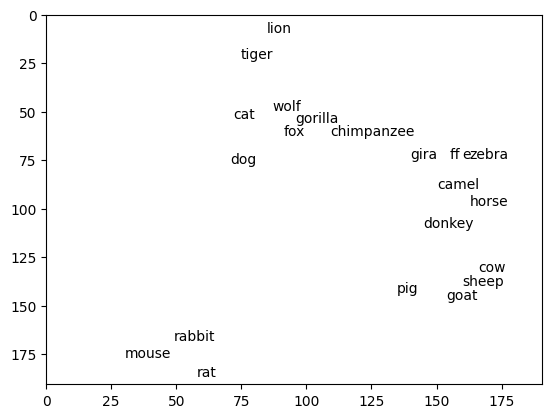

In [42]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import re

# Function to extract the coordinates from a 'transform' attribute
def parse_transform(transform):
    match = re.search(r"translate\((.*?)\)", transform)
    if match:
        # Split by any whitespace or comma
        coords = re.split(r'[,\s]+', match.group(1).strip())
        print(f"Parsed transform coordinates: {coords}")
        # Now coords[0] should be the x value and coords[1] should be the y value
        x_trans = float(coords[0])
        y_trans = float(coords[1]) if len(coords) > 1 else 0
        return x_trans, y_trans
    return 0, 0

# Function to extract text elements and their coordinates
def extract_text_coordinates(root):
    text_positions = []

    for text_element in root.iter('{http://www.w3.org/2000/svg}text'):
        # Extract position and content of each text element
        x = float(text_element.attrib.get('x', 0))  # Default to 0 if x not found
        y = float(text_element.attrib.get('y', 0))  # Default to 0 if y not found

        # Handle 'transform' attribute if present
        transform = text_element.attrib.get('transform')
        if transform:
            x_trans, y_trans = parse_transform(transform)
            x += x_trans
            y += y_trans

        text = ''.join(text_element.itertext()).strip()
        text_positions.append((x, y, text))

    return text_positions

# Function to generate TikZ code
def generate_tikz_code(text_positions):
    tikz_code = "\\begin{tikzpicture}\n"
    tikz_code += "\\begin{axis}[\n"
    tikz_code += "    width=190.57mm,\n"
    tikz_code += "    height=190.57mm,\n"
    tikz_code += "    xmin=0, xmax=190.57,\n"
    tikz_code += "    ymin=0, ymax=190.57,\n"
    tikz_code += "    axis on top,\n"
    tikz_code += "    y dir=reverse,\n"
    tikz_code += "]\n"

    for (x, y, text) in text_positions:
        tikz_code += f"    \\node at (axis cs:{x},{y}) {{{text}}};\n"

    tikz_code += "\\end{axis}\n"
    tikz_code += "\\end{tikzpicture}\n"

    return tikz_code


# Load the SVG file
svg_content = '''<svg id="Calque_1" data-name="Calque 1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" width="67.23mm" height="67.23mm" viewBox="0 0 190.57 190.57">
  <defs>
    <style>
      .cls-1, .cls-4 {
        fill: none;
      }

      .cls-2 {
        clip-path: url(#clip-path);
      }

      .cls-3 {
        clip-path: url(#clip-path-2);
      }

      .cls-4 {
        stroke: #d1d1e1;
        stroke-miterlimit: 10;
        stroke-width: 0.44px;
        stroke-dasharray: 1.1 1.1;
      }

      .cls-5 {
        clip-path: url(#clip-path-3);
      }

      .cls-6 {
        clip-path: url(#clip-path-4);
      }

      .cls-7 {
        clip-path: url(#clip-path-5);
      }

      .cls-8 {
        clip-path: url(#clip-path-6);
      }

      .cls-9 {
        clip-path: url(#clip-path-7);
      }

      .cls-10 {
        clip-path: url(#clip-path-8);
      }

      .cls-11 {
        clip-path: url(#clip-path-9);
      }

      .cls-12 {
        clip-path: url(#clip-path-10);
      }

      .cls-13 {
        clip-path: url(#clip-path-11);
      }

      .cls-14 {
        clip-path: url(#clip-path-12);
      }

      .cls-15, .cls-20, .cls-29, .cls-39, .cls-45 {
        font-size: 6.24px;
        fill: #4d414c;
        font-family: DejaVuSans;
      }

      .cls-16, .cls-20 {
        letter-spacing: -0.05em;
      }

      .cls-17 {
        letter-spacing: 0.01em;
      }

      .cls-18 {
        letter-spacing: 0.03em;
      }

      .cls-19 {
        letter-spacing: 0.01em;
      }

      .cls-21, .cls-39 {
        letter-spacing: -0.01em;
      }

      .cls-22 {
        letter-spacing: -0.03em;
      }

      .cls-23 {
        letter-spacing: 0.02em;
      }

      .cls-24 {
        letter-spacing: -0.01em;
      }

      .cls-25 {
        letter-spacing: 0.01em;
      }

      .cls-26 {
        letter-spacing: -0.02em;
      }

      .cls-27 {
        letter-spacing: 0em;
      }

      .cls-28 {
        letter-spacing: 0.01em;
      }

      .cls-29, .cls-31 {
        letter-spacing: -0.01em;
      }

      .cls-30 {
        letter-spacing: 0em;
      }

      .cls-32 {
        letter-spacing: -0.01em;
      }

      .cls-33 {
        letter-spacing: -0.08em;
      }

      .cls-34 {
        letter-spacing: 0.01em;
      }

      .cls-35 {
        letter-spacing: 0.02em;
      }

      .cls-36 {
        letter-spacing: -0.03em;
      }

      .cls-37, .cls-45 {
        letter-spacing: -0.04em;
      }

      .cls-38 {
        letter-spacing: -0.03em;
      }

      .cls-40 {
        letter-spacing: -0.02em;
      }

      .cls-41 {
        letter-spacing: 0.01em;
      }

      .cls-42 {
        letter-spacing: 0.01em;
      }

      .cls-43 {
        letter-spacing: -0.01em;
      }

      .cls-44 {
        letter-spacing: 0.01em;
      }

      .cls-46 {
        letter-spacing: -0.02em;
      }

      .cls-47 {
        letter-spacing: -0.01em;
      }

      .cls-48 {
        letter-spacing: 0.06em;
      }
    </style>
    <clipPath id="clip-path" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="-67.67" y="-9.49" width="312.52" height="220.99"/>
    </clipPath>
    <clipPath id="clip-path-2" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="1.36" y="186.97" width="190.57" height="1.56"/>
    </clipPath>
    <clipPath id="clip-path-3" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="1.36" y="156.56" width="190.57" height="1.56"/>
    </clipPath>
    <clipPath id="clip-path-4" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="1.36" y="126.16" width="190.57" height="1.56"/>
    </clipPath>
    <clipPath id="clip-path-5" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="1.36" y="96.54" width="190.57" height="0.78"/>
    </clipPath>
    <clipPath id="clip-path-6" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="1.36" y="66.13" width="190.57" height="0.78"/>
    </clipPath>
    <clipPath id="clip-path-7" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="1.36" y="35.73" width="190.57" height="0.78"/>
    </clipPath>
    <clipPath id="clip-path-8" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="1.36" y="5.32" width="190.57" height="1.56"/>
    </clipPath>
    <clipPath id="clip-path-9" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="4.83" y="1.56" width="1.56" height="190.57"/>
    </clipPath>
    <clipPath id="clip-path-10" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="65.64" y="1.56" width="1.56" height="190.57"/>
    </clipPath>
    <clipPath id="clip-path-11" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="126.44" y="1.56" width="0.78" height="190.57"/>
    </clipPath>
    <clipPath id="clip-path-12" transform="translate(-1.36 -1.56)">
      <rect class="cls-1" x="187.25" y="1.56" width="0.78" height="190.57"/>
    </clipPath>
  </defs>
  <title>svg_format</title>
  <g class="cls-2">
    <g class="cls-3">
      <line class="cls-4" y1="186.15" x2="190.57" y2="186.15"/>
    </g>
    <g class="cls-5">
      <line class="cls-4" y1="155.86" x2="190.57" y2="155.86"/>
    </g>
    <g class="cls-6">
      <line class="cls-4" y1="125.57" x2="190.57" y2="125.57"/>
    </g>
    <g class="cls-7">
      <line class="cls-4" y1="95.29" x2="190.57" y2="95.29"/>
    </g>
    <g class="cls-8">
      <line class="cls-4" y1="65" x2="190.57" y2="65"/>
    </g>
    <g class="cls-9">
      <line class="cls-4" y1="34.71" x2="190.57" y2="34.71"/>
    </g>
    <g class="cls-10">
      <line class="cls-4" y1="4.42" x2="190.57" y2="4.42"/>
    </g>
    <g class="cls-11">
      <line class="cls-4" x1="4.42" x2="4.42" y2="190.57"/>
    </g>
    <g class="cls-12">
      <line class="cls-4" x1="65" x2="65" y2="190.57"/>
    </g>
    <g class="cls-13">
      <line class="cls-4" x1="125.57" x2="125.57" y2="190.57"/>
    </g>
    <g class="cls-14">
      <line class="cls-4" x1="186.15" x2="186.15" y2="190.57"/>
    </g>
    <text class="cls-15" transform="translate(158.52 89.7)"><tspan class="cls-16">c</tspan><tspan class="cls-17" x="2.48" y="0">a</tspan><tspan class="cls-18" x="5.56" y="0">m</tspan><tspan class="cls-19" x="10.91" y="0">e</tspan><tspan x="14.09" y="0">l</tspan></text>
    <text class="cls-15" transform="translate(76.03 53.31)"><tspan class="cls-16">c</tspan><tspan class="cls-17" x="2.48" y="0">a</tspan><tspan x="5.56" y="0">t</tspan></text>
    <text class="cls-20" transform="translate(125.44 62.07)">c<tspan class="cls-21" x="2.48" y="0">h</tspan><tspan class="cls-22" x="5.89" y="0">i</tspan><tspan class="cls-23" x="7.18" y="0">m</tspan><tspan class="cls-24" x="12.53" y="0">p</tspan><tspan class="cls-25" x="16.02" y="0">a</tspan><tspan class="cls-21" x="19.1" y="0">n</tspan><tspan class="cls-26" x="22.5" y="0">z</tspan><tspan class="cls-19" x="25.02" y="0">e</tspan><tspan class="cls-27" x="28.2" y="0">e</tspan></text>
    <text class="cls-15" transform="translate(171.2 132.4)"><tspan class="cls-16">c</tspan><tspan class="cls-28" x="2.48" y="0">o</tspan><tspan x="5.98" y="0">w</tspan></text>
    <text class="cls-29" transform="translate(75.94 76.52)">d<tspan class="cls-28" x="3.46" y="0">o</tspan><tspan class="cls-30" x="6.95" y="0">g</tspan></text>
    <text class="cls-15" transform="translate(154.55 109.46)"><tspan class="cls-31">d</tspan><tspan class="cls-28" x="3.46" y="0">o</tspan><tspan class="cls-32" x="6.95" y="0">n</tspan><tspan class="cls-33" x="10.37" y="0">k</tspan><tspan class="cls-34" x="12.8" y="0">e</tspan><tspan x="15.97" y="0">y</tspan></text>
    <text class="cls-15" transform="translate(95.47 61.95)"><tspan class="cls-35">f</tspan><tspan class="cls-28" x="1.96" y="0">o</tspan><tspan x="5.46" y="0">x</tspan></text>
    <text class="cls-15" transform="translate(145.3 74.08)"><tspan class="cls-31">g</tspan><tspan class="cls-36" x="3.42" y="0">i</tspan><tspan class="cls-37" x="4.71" y="0">r</tspan><tspan x="6.52" y="0">a</tspan></text>
    <text class="cls-15" transform="translate(156.97 74.08)">ﬀ</text>
    <text class="cls-15" transform="translate(161.65 74.08)">e</text>
    <text class="cls-15" transform="translate(159.82 146.51)"><tspan class="cls-31">g</tspan><tspan class="cls-28" x="3.42" y="0">oa</tspan><tspan x="10" y="0">t</tspan></text>
    <text class="cls-15" transform="translate(104.12 55.36)"><tspan class="cls-31">g</tspan><tspan class="cls-28" x="3.42" y="0">o</tspan><tspan class="cls-37" x="6.92" y="0">r</tspan><tspan class="cls-36" x="8.74" y="0">i</tspan><tspan class="cls-22" x="10.02" y="0">l</tspan><tspan class="cls-38" x="11.33" y="0">l</tspan><tspan x="12.62" y="0">a</tspan></text>
    <text class="cls-39" transform="translate(170.16 98.37)">h<tspan class="cls-28" x="3.41" y="0">o</tspan><tspan class="cls-37" x="6.9" y="0">r</tspan><tspan class="cls-40" x="8.72" y="0">s</tspan><tspan class="cls-27" x="11.06" y="0">e</tspan></text>
    <text class="cls-15" transform="translate(89.7 8.8)"><tspan class="cls-38">li</tspan><tspan class="cls-41" x="2.58" y="0">o</tspan><tspan x="6.09" y="0">n</tspan></text>
    <text class="cls-15" transform="translate(39.17 176.36)"><tspan class="cls-18">m</tspan><tspan class="cls-42" x="5.36" y="0">o</tspan><tspan class="cls-43" x="8.86" y="0">u</tspan><tspan class="cls-40" x="12.24" y="0">s</tspan><tspan x="14.58" y="0">e</tspan></text>
    <text class="cls-15" transform="translate(138.77 143.08)"><tspan class="cls-31">p</tspan><tspan class="cls-38" x="3.49" y="0">i</tspan><tspan x="4.77" y="0">g</tspan></text>
    <text class="cls-15" transform="translate(57.03 167.58)"><tspan class="cls-37">r</tspan><tspan class="cls-44" x="1.81" y="0">a</tspan><tspan class="cls-31" x="4.89" y="0">b</tspan><tspan class="cls-24" x="8.38" y="0">b</tspan><tspan class="cls-38" x="11.87" y="0">i</tspan><tspan x="13.15" y="0">t</tspan></text>
    <text class="cls-45" transform="translate(61.86 186.33)">r<tspan class="cls-44" x="1.81" y="0">a</tspan><tspan class="cls-30" x="4.89" y="0">t</tspan></text>
    <text class="cls-15" transform="translate(167.89 139.48)"><tspan class="cls-40">s</tspan><tspan class="cls-21" x="2.34" y="0">h</tspan><tspan class="cls-19" x="5.74" y="0">ee</tspan><tspan x="12.11" y="0">p</tspan></text>
    <text class="cls-15" transform="translate(81.08 22.56)"><tspan class="cls-46">t</tspan><tspan class="cls-38" x="1.96" y="0">i</tspan><tspan class="cls-47" x="3.24" y="0">g</tspan><tspan class="cls-19" x="6.67" y="0">e</tspan><tspan x="9.85" y="0">r</tspan></text>
    <text class="cls-15" transform="translate(92.32 49.3)"><tspan class="cls-48">w</tspan><tspan class="cls-28" x="4.94" y="0">o</tspan><tspan class="cls-38" x="8.44" y="0">l</tspan><tspan x="9.74" y="0">f</tspan></text>
    <text class="cls-15" transform="translate(169.96 74.06)"><tspan class="cls-26">z</tspan><tspan class="cls-19" x="2.51" y="0">e</tspan><tspan class="cls-31" x="5.69" y="0">b</tspan><tspan class="cls-37" x="9.18" y="0">r</tspan><tspan x="11" y="0">a</tspan></text>
  </g>
</svg>'''

# Parse the SVG content
root = ET.fromstring(svg_content)

# Extract text and their positions
text_positions = extract_text_coordinates(root)

# Generate TikZ code
tikz_code = generate_tikz_code(text_positions)

# Write TikZ code to a file
with open('/content/file.TikZ', 'w') as f:
    f.write(tikz_code)

# Visualization using Matplotlib (optional, for verification)
fig, ax = plt.subplots()

# Set axis limits based on the SVG viewBox
ax.set_xlim(0, 190.57)
ax.set_ylim(0, 190.57)
ax.invert_yaxis()  # Invert the y-axis to match SVG coordinate system

# Plot the text elements
for (x, y, text) in text_positions:
    ax.text(x, y, text, fontsize=10, ha='center')

# Show the plot
plt.show()

In [44]:
import re

def reduce_coordinates(input_code, factor=2):
    # Regular expression to match coordinate pairs
    coord_pattern = r'(\d+\.\d+),(\d+\.\d+)'

    def reduce_coord(match):
        x = float(match.group(1)) / factor
        y = float(match.group(2)) / factor
        return f"{x:.2f},{y:.2f}"

    # Replace coordinates in the input code
    modified_code = re.sub(coord_pattern, reduce_coord, input_code)

    # Adjust width and height
    modified_code = re.sub(r'(width|height)=(\d+\.\d+)mm',
                           lambda m: f"{m.group(1)}={float(m.group(2))/factor:.2f}mm",
                           modified_code)

    # Adjust xmax and ymax
    modified_code = re.sub(r'(xmax|ymax)=(\d+\.\d+)',
                           lambda m: f"{m.group(1)}={float(m.group(2))/factor:.2f}",
                           modified_code)

    return modified_code

# Original TikZ code
original_code = r"""\documentclass{standalone}
\usepackage{pgfplots}
\pgfplotsset{compat=1.18}

\begin{document}

\begin{tikzpicture}
\begin{axis}[
    width=190.57mm,
    height=190.57mm,
    xmin=0, xmax=190.57,
    ymin=0, ymax=190.57,
    axis on top,
    y dir=reverse,
    xtick=\empty,
    ytick=\empty,
]
    \node at (axis cs:158.52,89.7) {camel};
    \node at (axis cs:76.03,53.31) {cat};
    \node at (axis cs:125.44,62.07) {chimpanzee};
    \node at (axis cs:171.2,132.4) {cow};
    \node at (axis cs:75.94,76.52) {dog};
    \node at (axis cs:154.55,109.46) {donkey};
    \node at (axis cs:95.47,61.95) {fox};
    \node at (axis cs:156.97,74.08) {giraffe};
    \node at (axis cs:159.82,146.51) {goat};
    \node at (axis cs:104.12,55.36) {gorilla};
    \node at (axis cs:156.97,74.08) {ﬀ};
    \node at (axis cs:170.16,98.37) {horse};
    \node at (axis cs:89.7,8.8) {lion};
    \node at (axis cs:39.17,176.36) {mouse};
    \node at (axis cs:138.77,143.08) {pig};
    \node at (axis cs:57.03,167.58) {rabbit};
    \node at (axis cs:61.86,186.33) {rat};
    \node at (axis cs:167.89,139.48) {sheep};
    \node at (axis cs:81.08,22.56) {tiger};
    \node at (axis cs:92.32,49.3) {wolf};
    \node at (axis cs:169.96,74.06) {zebra};
\end{axis}
\end{tikzpicture}

\end{document}"""

# Reduce coordinates
modified_code = reduce_coordinates(original_code)

# Print the modified code
print(modified_code)

\documentclass{standalone}
\usepackage{pgfplots}
\pgfplotsset{compat=1.18}

\begin{document}

\begin{tikzpicture}
\begin{axis}[
    width=95.28mm,
    height=95.28mm,
    xmin=0, xmax=95.28,
    ymin=0, ymax=95.28,
    axis on top,
    y dir=reverse,
    xtick=\empty,
    ytick=\empty,
]
    \node at (axis cs:79.26,44.85) {camel};
    \node at (axis cs:38.02,26.66) {cat};
    \node at (axis cs:62.72,31.04) {chimpanzee};
    \node at (axis cs:85.60,66.20) {cow};
    \node at (axis cs:37.97,38.26) {dog};
    \node at (axis cs:77.28,54.73) {donkey};
    \node at (axis cs:47.73,30.98) {fox};
    \node at (axis cs:78.48,37.04) {giraffe};
    \node at (axis cs:79.91,73.25) {goat};
    \node at (axis cs:52.06,27.68) {gorilla};
    \node at (axis cs:78.48,37.04) {ﬀ};
    \node at (axis cs:85.08,49.19) {horse};
    \node at (axis cs:44.85,4.40) {lion};
    \node at (axis cs:19.59,88.18) {mouse};
    \node at (axis cs:69.39,71.54) {pig};
    \node at (axis cs:28.52,83.79) {rabbit};
    \node at 

In [37]:
def parse_transform(transform):
    match = re.search(r"translate\((.*?)\)", transform)
    if match:
        coords = match.group(1).split(',')
        print(f"Parsed transform coordinates: {coords}")
        x_trans = float(coords[0])
        y_trans = float(coords[1]) if len(coords) > 1 else 0
        return x_trans, y_trans
    return 0, 0


In [22]:
import xml.etree.ElementTree as ET

def extract_text_positions(svg_file):
    tree = ET.parse(svg_file)
    root = tree.getroot()

    # Namespace of the SVG file
    ns = {'svg': 'http://www.w3.org/2000/svg'}

    # Find all text elements in the SVG
    text_elements = root.findall('.//svg:text', ns)

    for text_elem in text_elements:
        text = text_elem.text
        x = text_elem.attrib.get('x')
        y = text_elem.attrib.get('y')
        print(f'Text: {text}, X: {x}, Y: {y}')

# Call the function with your SVG file
extract_text_positions('file.svg')


Text: None, X: None, Y: None
Text: None, X: None, Y: None
Text: c, X: None, Y: None
Text: None, X: None, Y: None
Text: d, X: None, Y: None
Text: None, X: None, Y: None
Text: None, X: None, Y: None
Text: None, X: None, Y: None
Text: ﬀ, X: None, Y: None
Text: e, X: None, Y: None
Text: None, X: None, Y: None
Text: None, X: None, Y: None
Text: h, X: None, Y: None
Text: None, X: None, Y: None
Text: None, X: None, Y: None
Text: None, X: None, Y: None
Text: None, X: None, Y: None
Text: r, X: None, Y: None
Text: None, X: None, Y: None
Text: None, X: None, Y: None
Text: None, X: None, Y: None
Text: None, X: None, Y: None
